# FAKE NEWS DETECTION

**Libraries Importation**

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import dump
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from joblib import load
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\20127\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\20127\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\20127\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df=pd.read_csv("news.csv")

In [4]:
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


**1.Preprocessing**

In [5]:
#convert to lower case to avoid issues where the same word in different cases is treated as different words.
df['title'] = df['title'].str.lower()
df['text'] = df['text'].str.lower()


In [6]:
df.label = df.label.astype(str)
df.label = df.label.str.strip()
dict = { 'REAL' : '1' , 'FAKE' : '0'}
df['label'] = df['label'].map(dict)
df.head()

,Unnamed: 0,title,text,label
0,8476,you can smell hillary’s fear,"daniel greenfield, a shillman journalism fello...",0
1,10294,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0
2,3608,kerry to go to paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,1
3,10142,bernie supporters on twitter erupt in anger ag...,"— kaydee king (@kaydeeking) november 9, 2016 t...",0
4,875,the battle of new york: why this primary matters,it's primary day in new york and front-runners...,1


In [7]:
# Drop nulls
df.isna().sum()
print(f"Before {df.isna().sum()}")
df = df.dropna()
print(f"After {df.isna().sum()}")
# Reset the index after dropping rows
df = df.reset_index(drop=True)


Before Unnamed: 0    0
title         0
text          0
label         0
dtype: int64
After Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


In [8]:
#duplicates
has_duplicates = df.duplicated().any()
if has_duplicates:
    df.drop_duplicates(inplace=True)

In [9]:
c=0
for row in df['title']:
    if row == ' ':
        c+=1
print(c)

0


In [10]:
df

,Unnamed: 0,title,text,label
0,8476,you can smell hillary’s fear,"daniel greenfield, a shillman journalism fello...",0
1,10294,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0
2,3608,kerry to go to paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,1
3,10142,bernie supporters on twitter erupt in anger ag...,"— kaydee king (@kaydeeking) november 9, 2016 t...",0
4,875,the battle of new york: why this primary matters,it's primary day in new york and front-runners...,1
...,...,...,...,...
6330,4490,state department says it can't find emails fro...,the state department told the republican natio...,1
6331,8062,the ‘p’ in pbs should stand for ‘plutocratic’ ...,the ‘p’ in pbs should stand for ‘plutocratic’ ...,0
6332,8622,anti-trump protesters are tools of the oligarc...,anti-trump protesters are tools of the oligar...,0
6333,4021,"in ethiopia, obama seeks progress on peace, se...","addis ababa, ethiopia —president obama convene...",1


In [11]:
### rows that doesn't have text in it########
c=0
listOfIndcies=[]
for row in df['text']:
    if row == ' ':
        listOfIndcies=(df.index[df['text']==row].tolist())
        c+=1
print(c)

36


In [12]:
listOfIndcies

[106,
 710,
 806,
 919,
 940,
 1664,
 1736,
 1851,
 1883,
 1941,
 2244,
 2426,
 2576,
 2662,
 2788,
 2832,
 3073,
 3350,
 3511,
 3641,
 3642,
 4014,
 4142,
 4253,
 4713,
 4744,
 5017,
 5088,
 5213,
 5581,
 5639,
 5699,
 5772,
 6064,
 6175,
 6328]

In [13]:
df = df.drop(labels=listOfIndcies,axis=0)

In [14]:
df

,Unnamed: 0,title,text,label
0,8476,you can smell hillary’s fear,"daniel greenfield, a shillman journalism fello...",0
1,10294,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0
2,3608,kerry to go to paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,1
3,10142,bernie supporters on twitter erupt in anger ag...,"— kaydee king (@kaydeeking) november 9, 2016 t...",0
4,875,the battle of new york: why this primary matters,it's primary day in new york and front-runners...,1
...,...,...,...,...
6330,4490,state department says it can't find emails fro...,the state department told the republican natio...,1
6331,8062,the ‘p’ in pbs should stand for ‘plutocratic’ ...,the ‘p’ in pbs should stand for ‘plutocratic’ ...,0
6332,8622,anti-trump protesters are tools of the oligarc...,anti-trump protesters are tools of the oligar...,0
6333,4021,"in ethiopia, obama seeks progress on peace, se...","addis ababa, ethiopia —president obama convene...",1


In [15]:
c=0
for row in df['text']:
    if row == ' ':
        c+=1
print(c)

0


In [16]:
df=df.reset_index(drop=True)

In [17]:
df

,Unnamed: 0,title,text,label
0,8476,you can smell hillary’s fear,"daniel greenfield, a shillman journalism fello...",0
1,10294,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0
2,3608,kerry to go to paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,1
3,10142,bernie supporters on twitter erupt in anger ag...,"— kaydee king (@kaydeeking) november 9, 2016 t...",0
4,875,the battle of new york: why this primary matters,it's primary day in new york and front-runners...,1
...,...,...,...,...
6294,4490,state department says it can't find emails fro...,the state department told the republican natio...,1
6295,8062,the ‘p’ in pbs should stand for ‘plutocratic’ ...,the ‘p’ in pbs should stand for ‘plutocratic’ ...,0
6296,8622,anti-trump protesters are tools of the oligarc...,anti-trump protesters are tools of the oligar...,0
6297,4021,"in ethiopia, obama seeks progress on peace, se...","addis ababa, ethiopia —president obama convene...",1


In [18]:
unique_ids = df['Unnamed: 0'].unique()
id_mapping = {original_id: new_id for new_id, original_id in enumerate(unique_ids)}
df['Unnamed: 0'] = df['Unnamed: 0'].map(id_mapping)
df.rename(columns={'Unnamed: 0': "ID"},inplace=True)
df

,ID,title,text,label
0,0,you can smell hillary’s fear,"daniel greenfield, a shillman journalism fello...",0
1,1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0
2,2,kerry to go to paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,1
3,3,bernie supporters on twitter erupt in anger ag...,"— kaydee king (@kaydeeking) november 9, 2016 t...",0
4,4,the battle of new york: why this primary matters,it's primary day in new york and front-runners...,1
...,...,...,...,...
6294,6294,state department says it can't find emails fro...,the state department told the republican natio...,1
6295,6295,the ‘p’ in pbs should stand for ‘plutocratic’ ...,the ‘p’ in pbs should stand for ‘plutocratic’ ...,0
6296,6296,anti-trump protesters are tools of the oligarc...,anti-trump protesters are tools of the oligar...,0
6297,6297,"in ethiopia, obama seeks progress on peace, se...","addis ababa, ethiopia —president obama convene...",1


In [19]:
#Tokenize&Limmmatize&POS_Tagging

###################################################
tokenizer = RegexpTokenizer(r'\w+')
def remove_punctuation_tokenize_and_remove_stopwords(text):
    # Remove_punctuation
    cleaned_text =re.sub(r'[^\w\s]', '', str(text))
    tokenized_text = tokenizer.tokenize(cleaned_text)
    #remove_stopwords
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in tokenized_text if word.lower() not in stop_words]
    return filtered_text
####################################################
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return None
####################################################
lemmatizer = WordNetLemmatizer()

def pos_tag_and_lemmatize(tokenized_words):
    pos_tagged_words = pos_tag(tokenized_words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) if get_wordnet_pos(tag)
                        else word for word, tag in pos_tagged_words]
    return lemmatized_words






In [20]:
# #  preprocessing (title & text )
# ############DONOT RUN This cell if u already saved them############
# text_column = 'text'
# title_column="title"
# df['tokenized_text'] = df[text_column].apply(remove_punctuation_tokenize_and_remove_stopwords)
# df['lemmatized_text'] = df['tokenized_text'].apply(pos_tag_and_lemmatize)
# df['tokenized_title'] =df[title_column].apply(remove_punctuation_tokenize_and_remove_stopwords)
# df['lemmatized_title'] =df['tokenized_title'].apply(pos_tag_and_lemmatize)
# with open('preprocessed_data.pkl', 'wb') as f:
#     pickle.dump(df, f)

# print("Preprocessed data saved successfully!")
# ############Saving them instead of running everytime#########

In [21]:
###############Loading them#################
with open('preprocessed_data.pkl', 'rb') as f:
    df = pickle.load(f)

In [22]:
df

,ID,title,text,label,tokenized_text,lemmatized_text,tokenized_title,lemmatized_title
0,0,you can smell hillary’s fear,"daniel greenfield, a shillman journalism fello...",0,"[daniel, greenfield, shillman, journalism, fel...","[daniel, greenfield, shillman, journalism, fel...","[smell, hillarys, fear]","[smell, hillarys, fear]"
1,1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0,"[google, pinterest, digg, linkedin, reddit, st...","[google, pinterest, digg, linkedin, reddit, st...","[watch, exact, moment, paul, ryan, committed, ...","[watch, exact, moment, paul, ryan, commit, pol..."
2,2,kerry to go to paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,1,"[us, secretary, state, john, f, kerry, said, m...","[us, secretary, state, john, f, kerry, say, mo...","[kerry, go, paris, gesture, sympathy]","[kerry, go, paris, gesture, sympathy]"
3,3,bernie supporters on twitter erupt in anger ag...,"— kaydee king (@kaydeeking) november 9, 2016 t...",0,"[kaydee, king, kaydeeking, november, 9, 2016, ...","[kaydee, king, kaydeeking, november, 9, 2016, ...","[bernie, supporters, twitter, erupt, anger, dn...","[bernie, supporter, twitter, erupt, anger, dnc..."
4,4,the battle of new york: why this primary matters,it's primary day in new york and front-runners...,1,"[primary, day, new, york, frontrunners, hillar...","[primary, day, new, york, frontrunners, hillar...","[battle, new, york, primary, matters]","[battle, new, york, primary, matter]"
...,...,...,...,...,...,...,...,...
6294,6294,state department says it can't find emails fro...,the state department told the republican natio...,1,"[state, department, told, republican, national...","[state, department, tell, republican, national...","[state, department, says, cant, find, emails, ...","[state, department, say, cant, find, emails, c..."
6295,6295,the ‘p’ in pbs should stand for ‘plutocratic’ ...,the ‘p’ in pbs should stand for ‘plutocratic’ ...,0,"[p, pbs, stand, plutocratic, pentagon, posted,...","[p, pb, stand, plutocratic, pentagon, post, oc...","[p, pbs, stand, plutocratic, pentagon]","[p, pb, stand, plutocratic, pentagon]"
6296,6296,anti-trump protesters are tools of the oligarc...,anti-trump protesters are tools of the oligar...,0,"[antitrump, protesters, tools, oligarchy, refo...","[antitrump, protester, tool, oligarchy, reform...","[antitrump, protesters, tools, oligarchy, info...","[antitrump, protester, tool, oligarchy, inform..."
6297,6297,"in ethiopia, obama seeks progress on peace, se...","addis ababa, ethiopia —president obama convene...",1,"[addis, ababa, ethiopia, president, obama, con...","[addis, ababa, ethiopia, president, obama, con...","[ethiopia, obama, seeks, progress, peace, secu...","[ethiopia, obama, seek, progress, peace, secur..."


In [23]:
Y = df['label']
Y

0       0
1       0
2       1
3       0
4       1
       ..
6294    1
6295    0
6296    0
6297    1
6298    1
Name: label, Length: 6299, dtype: object

In [24]:
df.shape

(6299, 8)

**2.Feature Extraction &&&& TF-IDF**

In [25]:
X = df.drop(['title','text','tokenized_text','tokenized_title','label','ID'], axis=1)

In [26]:
X

,lemmatized_text,lemmatized_title
0,"[daniel, greenfield, shillman, journalism, fel...","[smell, hillarys, fear]"
1,"[google, pinterest, digg, linkedin, reddit, st...","[watch, exact, moment, paul, ryan, commit, pol..."
2,"[us, secretary, state, john, f, kerry, say, mo...","[kerry, go, paris, gesture, sympathy]"
3,"[kaydee, king, kaydeeking, november, 9, 2016, ...","[bernie, supporter, twitter, erupt, anger, dnc..."
4,"[primary, day, new, york, frontrunners, hillar...","[battle, new, york, primary, matter]"
...,...,...
6294,"[state, department, tell, republican, national...","[state, department, say, cant, find, emails, c..."
6295,"[p, pb, stand, plutocratic, pentagon, post, oc...","[p, pb, stand, plutocratic, pentagon]"
6296,"[antitrump, protester, tool, oligarchy, reform...","[antitrump, protester, tool, oligarchy, inform..."
6297,"[addis, ababa, ethiopia, president, obama, con...","[ethiopia, obama, seek, progress, peace, secur..."


In [27]:
####### Applying tf_idf#####
X['combined_text'] = X['lemmatized_text'].apply(lambda x: ' '.join(x)) + ' ' + X['lemmatized_title'].apply(lambda x: ' '.join(x))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X['combined_text'])

print(tfidf_matrix)

  (0, 24541)	0.01931317300642821
  (0, 12977)	0.01503765807506309
  (0, 4747)	0.028660409351334515
  (0, 35310)	0.02826265924011383
  (0, 13550)	0.02993238528426158
  (0, 15173)	0.013128333867747652
  (0, 64918)	0.011596049580538942
  (0, 49075)	0.014073204632965504
  (0, 64660)	0.020814756684917796
  (0, 19658)	0.02322417387033413
  (0, 50525)	0.025384690827917247
  (0, 77635)	0.026796336163326627
  (0, 67279)	0.015297654270888068
  (0, 41304)	0.011303615140255489
  (0, 44824)	0.011901254071299654
  (0, 62893)	0.02320613529390864
  (0, 73257)	0.028706319495839752
  (0, 58568)	0.024836301589830172
  (0, 16446)	0.015200517484901655
  (0, 9506)	0.015448843005845174
  (0, 67563)	0.019157801311690037
  (0, 14359)	0.023333588521725544
  (0, 75190)	0.02021240959690712
  (0, 64000)	0.01913080581379957
  (0, 6736)	0.0184486129955619
  :	:
  (6298, 8073)	0.0375450894777581
  (6298, 13920)	0.041663444511035354
  (6298, 71229)	0.011568613132266474
  (6298, 68202)	0.026129175700626433
  (6298, 209

In [28]:
X

,lemmatized_text,lemmatized_title,combined_text
0,"[daniel, greenfield, shillman, journalism, fel...","[smell, hillarys, fear]",daniel greenfield shillman journalism fellow f...
1,"[google, pinterest, digg, linkedin, reddit, st...","[watch, exact, moment, paul, ryan, commit, pol...",google pinterest digg linkedin reddit stumbleu...
2,"[us, secretary, state, john, f, kerry, say, mo...","[kerry, go, paris, gesture, sympathy]",us secretary state john f kerry say monday sto...
3,"[kaydee, king, kaydeeking, november, 9, 2016, ...","[bernie, supporter, twitter, erupt, anger, dnc...",kaydee king kaydeeking november 9 2016 lesson ...
4,"[primary, day, new, york, frontrunners, hillar...","[battle, new, york, primary, matter]",primary day new york frontrunners hillary clin...
...,...,...,...
6294,"[state, department, tell, republican, national...","[state, department, say, cant, find, emails, c...",state department tell republican national comm...
6295,"[p, pb, stand, plutocratic, pentagon, post, oc...","[p, pb, stand, plutocratic, pentagon]",p pb stand plutocratic pentagon post oct 27 20...
6296,"[antitrump, protester, tool, oligarchy, reform...","[antitrump, protester, tool, oligarchy, inform...",antitrump protester tool oligarchy reform alwa...
6297,"[addis, ababa, ethiopia, president, obama, con...","[ethiopia, obama, seek, progress, peace, secur...",addis ababa ethiopia president obama convene m...


Splitting data

In [29]:
######splitting data to tarin and test######
tfidf_x_train, tfidf_x_test, y_train, y_test = train_test_split(tfidf_matrix, Y, test_size=0.2, random_state=0)

**3.MODELS**

**Model I:Logistic Regression**

In [30]:
#logistic regression
lr=LogisticRegression()
lr.fit(tfidf_x_train,y_train)
acc=lr.score(tfidf_x_test,y_test)
acct=lr.score(tfidf_x_train,y_train)
print("Train Accuracy is: ",acct*100)
print("Test Accuracy is: ",acc*100)

Train Accuracy is:  95.31653105774956
Test Accuracy is:  92.38095238095238


**Model II:Decision tree**

In [31]:
#Decision tree
dt=DecisionTreeClassifier()
dt.fit(tfidf_x_train,y_train)
acc=dt.score(tfidf_x_test,y_test)
acct=lr.score(tfidf_x_train,y_train)
print("Train Accuracy is: ",acct*100)
print("Test Accuracy is: ",acc*100)

Train Accuracy is:  95.31653105774956
Test Accuracy is:  82.22222222222221


**Model III:Passive Aggressive**

In [32]:
#passive agressive
pa=PassiveAggressiveClassifier(max_iter=150)
pa.fit(tfidf_x_train,y_train)
acc=pa.score(tfidf_x_test,y_test)
acct=pa.score(tfidf_x_train,y_train)
print("Train Accuracy is: ",acct*100)
print("Test Accuracy is: ",acc*100)

Train Accuracy is:  100.0
Test Accuracy is:  94.36507936507937


**Model IV:Naive Bayes**

In [33]:
#naive Bayes
nb=MultinomialNB()
nb.fit(tfidf_x_train,y_train)
acc=nb.score(tfidf_x_test,y_test)
acct=nb.score(tfidf_x_train,y_train)
print("Train Accuracy is: ",acct*100)
print("Test Accuracy is: ",acc*100)

Train Accuracy is:  88.76761262155189
Test Accuracy is:  83.41269841269842


**Model V:SVC**

In [34]:
# SVC
sv=SVC(kernel='linear')
sv.fit(tfidf_x_train,y_train)
acc=sv.score(tfidf_x_test,y_test)
acct=sv.score(tfidf_x_train,y_train)
print("Train Accuracy is: ",acct*100)
print("Test Accuracy is: ",acc*100)

Train Accuracy is:  99.04743004564398
Test Accuracy is:  94.52380952380952


**Or We can use the already saved models!**

In [35]:
############Loading Models##############
try:
    lr = load('logistic_regression_model.joblib')
    dt = load('decision_tree_model.joblib')
    pa = load('passive_aggressive_model.joblib')
    nb = load('naive_bayes_model.joblib')
    sv = load('support_vector_machine_model.joblib')
    
    print("Models loaded successfully!")
except FileNotFoundError:
    print("Saved models not found. Training models from scratch...")
    
    lr = LogisticRegression()
    lr.fit(tfidf_x_train, y_train)

    dt = DecisionTreeClassifier()
    dt.fit(tfidf_x_train, y_train)

    pa = PassiveAggressiveClassifier(max_iter=150)
    pa.fit(tfidf_x_train, y_train)

    nb = MultinomialNB()
    nb.fit(tfidf_x_train, y_train)

    sv = SVC(kernel='linear')
    sv.fit(tfidf_x_train, y_train)

    print("Models trained successfully!")

Models loaded successfully!


**4.Visualizing the results**

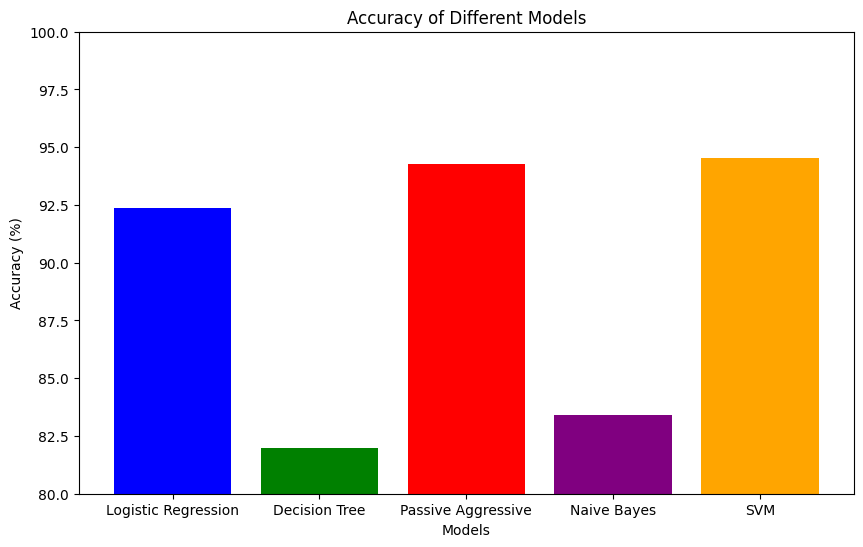

In [36]:
###########Visualize the result#############
models = ['Logistic Regression', 'Decision Tree', 'Passive Aggressive', 'Naive Bayes', 'SVM']
accuracies = [lr.score(tfidf_x_test, y_test) * 100,
              dt.score(tfidf_x_test, y_test) * 100,
              pa.score(tfidf_x_test, y_test) * 100,
              nb.score(tfidf_x_test, y_test) * 100,
              sv.score(tfidf_x_test, y_test) * 100]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Models')
plt.ylim(80, 100)
plt.show()

In [41]:
train_accuracies = [lr.score(tfidf_x_train, y_train) * 100,
                    dt.score(tfidf_x_train, y_train) * 100,
                    pa.score(tfidf_x_train, y_train) * 100,
                    nb.score(tfidf_x_train, y_train) * 100,
                    sv.score(tfidf_x_train, y_train) * 100]

data = {'Model': models, 'Train Accuracy (%)': train_accuracies, 'Test Accuracy (%)': accuracies}
dnew = pd.DataFrame(data)
dnew

,Model,Train Accuracy (%),Test Accuracy (%)
0,Logistic Regression,95.316531,92.380952
1,Decision Tree,100.000000,81.984127
2,Passive Aggressive,100.000000,94.285714
3,Naive Bayes,88.767613,83.412698
4,SVM,99.047430,94.523810


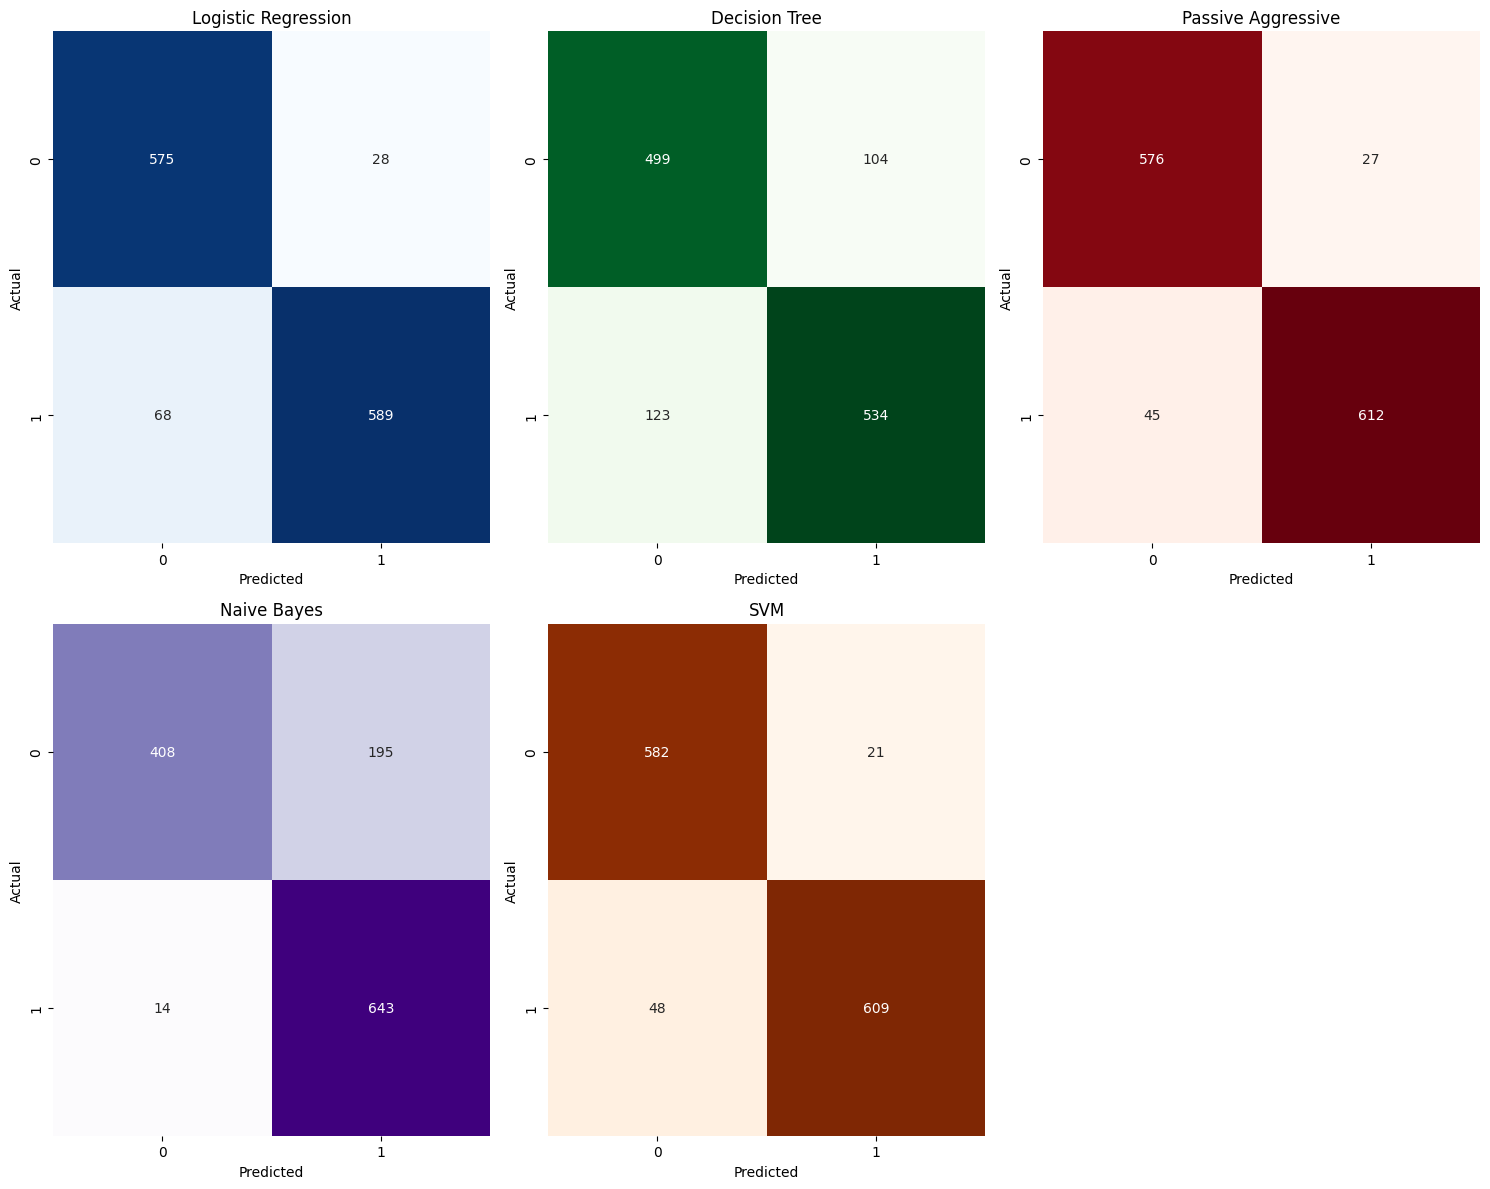

In [38]:
###################Confusion Matrix####################
lr_pred = lr.predict(tfidf_x_test)
dt_pred = dt.predict(tfidf_x_test)
pa_pred = pa.predict(tfidf_x_test)
nb_pred = nb.predict(tfidf_x_test)
sv_pred = sv.predict(tfidf_x_test)


cm_lr = confusion_matrix(y_test, lr_pred)
cm_dt = confusion_matrix(y_test, dt_pred)
cm_pa = confusion_matrix(y_test, pa_pred)
cm_nb = confusion_matrix(y_test, nb_pred)
cm_sv = confusion_matrix(y_test, sv_pred)


plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 2)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 3)
sns.heatmap(cm_pa, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Passive Aggressive')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 4)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 5)
sns.heatmap(cm_sv, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [39]:
###################Classification Report####################
print("Logistic Regression:")
print(classification_report(y_test, lr_pred))

print("Decision Tree:")
print(classification_report(y_test, dt_pred))

print("Passive Aggressive:")
print(classification_report(y_test, pa_pred))

print("Naive Bayes:")
print(classification_report(y_test, nb_pred))

print("Support Vector Machine:")
print(classification_report(y_test, sv_pred))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       603
           1       0.95      0.90      0.92       657

    accuracy                           0.92      1260
   macro avg       0.92      0.93      0.92      1260
weighted avg       0.93      0.92      0.92      1260

Decision Tree:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       603
           1       0.84      0.81      0.82       657

    accuracy                           0.82      1260
   macro avg       0.82      0.82      0.82      1260
weighted avg       0.82      0.82      0.82      1260

Passive Aggressive:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       603
           1       0.96      0.93      0.94       657

    accuracy                           0.94      1260
   macro avg       0.94      0.94      0.94      1260
weighted avg      

**5.Saving the models!**

In [40]:
############Saving the models#########
lr_model_path = 'logistic_regression_model.joblib'
dt_model_path = 'decision_tree_model.joblib'
pa_model_path = 'passive_aggressive_model.joblib'
nb_model_path = 'naive_bayes_model.joblib'
sv_model_path = 'support_vector_machine_model.joblib'

dump(lr, lr_model_path)
dump(dt, dt_model_path)
dump(pa, pa_model_path)
dump(nb, nb_model_path)
dump(sv, sv_model_path)

print("Models saved successfully!")

Models saved successfully!
